# Inerpretation-Net Training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes

config = {
    'data': {
        'd': 3, #degree
        'n': 10, #number of variables
        'monomial_vars': None, #int or None
        'laurent': False, #use Laurent polynomials (negative degree with up to -d)  
        'neg_d': 0,#int or None
        'neg_d_prob': 0,
        'sparsity': None,
        'sample_sparsity': 10,
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        'a_max': 1,
        'a_min': -1,
        'lambda_nets_total': 1000,
        'noise': 0,
        'noise_distrib': 'normal', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        
        'border_min': 0.2, #needs to be between 0 and (x_max-x_min)/2
        'border_max': 0.4,
        'lower_degree_prob': 0.5,
        'a_zero_prob': 0.25,
        'a_random_prob': 0.1,      
        
        'same_training_all_lambda_nets': False,

        'fixed_seed_lambda_training': True,
        'fixed_initialization_lambda_training': False,
        'number_different_lambda_trainings': 1,
    },
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True,  #if early stopping is used, multi_epoch_analysis is deactivated
        'early_stopping_min_delta_lambda': 1e-4,
        'batch_lambda': 64,
        'dropout': 0,
        'lambda_network_layers': [5*'sample_sparsity'],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'mae',
        'number_of_lambda_weights': None,
        'lambda_dataset_size': 5000,
    },
    'i_net': {
        'optimizer': 'custom',#adam
        'inet_loss': 'mae',
        'inet_metrics': ['r2'],
        'dropout': 0.25,
        'dropout_output': 0,
        'epochs': 2,#000, 
        'early_stopping': True,
        'batch_size': 256,
        'dense_layers': [512, 1024],
        'convolution_layers': None,
        'lstm_layers': None,
        'interpretation_dataset_size': 1000,
                
        'interpretation_net_output_monomials': 10, #(None, int) #CONSTANT IS NOT INCLUDED
        'interpretation_net_output_shape': None, #calculated automatically later
        'test_size': 100, #Float for fraction, Int for number 0
        
        'normalize_inet_data': False,
        'inet_training_without_noise': True, #dataset size without noise hardcoded to 50k in generate_paths
        'sparse_poly_representation_version': 1, #(1, 2); 1=old, 2=new

        'evaluate_with_real_function': False, #False
        'consider_labels_training': False, #False
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        'nas': False,
        'nas_type': 'SEQUENTIAL', #options:(None, 'SEQUENTIAL', 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 100,
    },
    'evaluation': {   
        'inet_holdout_seed_evaluation': False,
        
        #set if multi_epoch_analysis should be performed
        'multi_epoch_analysis': True,
        'each_epochs_save_lambda': 100,
        'epoch_start': 0, #use to skip first epochs in multi_epoch_analysis
        
        #set if samples analysis should be performed
        'samples_list': None,#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 
       
        'random_evaluation_dataset_size': 500,
        'per_network_optimization_dataset_size': 500,
        'max_optimization_minutes': 120,

        'adjusted_symbolic_metamodeling_code': False,
        'symbolic_metamodeling_evaluation': True,
        'symbolic_metamodeling_poly_evaluation': False,
        'symbolic_metamodeling_function_evaluation': False,
        'symbolic_metamodeling_poly_function_evaluation': False,
        
        
        'symbolic_regression_evaluation': False,
        'per_network_evaluation': False,
    },
    'computation':{
        'train_model': True,
        'n_jobs': -3,
        'use_gpu': True,
        'gpu_numbers': '3',
        'RANDOM_SEED': 0,   
    }
}

## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
from itertools import product       
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import os
import shutil

import logging

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold, ParameterGrid, ParameterSampler
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score

from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import tensorflow as tf
import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


import tensorflow.keras.backend as K
from livelossplot import PlotLossesKerasTF
#from keras_tqdm import TQDMNotebookCallback

from matplotlib import pyplot as plt
import seaborn as sns


import random 


import warnings

from IPython.display import Image
from IPython.display import display, Math, Latex, clear_output



In [4]:
tf.__version__

'2.4.1'

In [5]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n]

n_jobs = min((epochs_lambda//each_epochs_save_lambda+1, n_jobs)) if multi_epoch_analysis else min(len(samples_list), n_jobs) if samples_list!=None else 1

multi_epoch_analysis = False if early_stopping_lambda else multi_epoch_analysis #deactivate multi_epoch_analysis if early stopping is used

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda
epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1) if multi_epoch_analysis else range(1,2)

data_reshape_version = 2 if data_reshape_version == None and (convolution_layers != None or lstm_layers != None or (nas and nas_type != 'SEQUENTIAL')) else data_reshape_version
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
#os.environ['XLA_FLAGS'] =  '--xla_gpu_cuda_data_dir=/usr/lib/cuda-10.1'

logging.getLogger('tensorflow').disabled = True

sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

sys.path.append('..')

In [6]:
from utilities.utility_functions import flatten, rec_gen, gen_monomial_identifier_list

list_of_monomial_identifiers_extended = []

if laurent:
    variable_sets = [list(flatten([[_d for _d in range(d+1)], [-_d for _d in range(1, neg_d+1)]])) for _ in range(n)]
    list_of_monomial_identifiers_extended = rec_gen(variable_sets)    
        
    print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
    #print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
    #print('Sparsity:' + str(sparsity))
    if len(list_of_monomial_identifiers_extended) < 500:
        print(list_of_monomial_identifiers_extended)     
        
    list_of_monomial_identifiers = []
    for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
        if np.sum(monomial_identifier) <= d:
            if monomial_vars == None or len(list(filter(lambda x: x != 0, monomial_identifier))) <= monomial_vars:
                list_of_monomial_identifiers.append(monomial_identifier)        
else:
    variable_list = ['x'+ str(i) for i in range(n)]
    list_of_monomial_identifiers = gen_monomial_identifier_list(variable_list, d, n)
            
print('List length: ' + str(len(list_of_monomial_identifiers)))
#print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
#print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


List length: 286
[[3, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 1, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 1, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 1, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 1, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 1, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 1, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 1, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 1, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 1], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 2, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 1, 0, 0, 0, 0, 0, 0], [1, 1, 0, 0, 1, 0, 0, 0, 0, 0], [1, 1, 0, 0, 0, 1, 0, 0, 0, 0], [1, 1, 0, 0, 0, 0, 1, 0, 0, 0], [1, 1, 0, 0, 0, 0, 0, 1, 0, 0], [1, 1, 0, 0, 0, 0, 0, 0, 1, 0], [1, 1, 0, 0, 0, 0, 0, 0, 0, 1], [1, 1, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 2, 0, 0, 0, 0, 0, 0, 0], [1, 0, 1, 1, 0, 0, 0, 0, 0, 0], [1, 0, 1, 0, 1, 0, 0, 0, 0, 0], [1, 0, 1, 0, 0, 1, 0, 0, 0, 0], [1, 0, 1, 0, 0, 0, 1, 0, 0, 0], [1, 0, 1, 0, 0, 0, 0, 1, 0, 0], [1, 0, 1, 0, 0, 0, 0, 0, 1, 0], [1, 0, 1, 0, 0, 0, 0, 0, 0, 1], [1, 0, 1, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 2, 0, 0, 0, 

In [7]:
from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################
config['evaluation']['multi_epoch_analysis'] = multi_epoch_analysis
config['evaluation']['each_epochs_save_lambda'] = each_epochs_save_lambda
config['i_net']['data_reshape_version'] = data_reshape_version

config['data']['sparsity'] = nCr(config['data']['n']+config['data']['d'], config['data']['d']) if not laurent else len(list_of_monomial_identifiers)
config['data']['sample_sparsity'] = config['data']['sparsity'] if config['data']['sample_sparsity'] == None else config['data']['sample_sparsity']

config['i_net']['interpretation_net_output_shape'] = config['data']['sparsity'] if config['i_net']['interpretation_net_output_monomials'] is None else config['data']['sparsity']*config['i_net']['interpretation_net_output_monomials']+config['i_net']['interpretation_net_output_monomials'] if config['i_net']['sparse_poly_representation_version'] == 1 else config['data']['n']*(config['data']['d']+1)*config['i_net']['interpretation_net_output_monomials']+config['i_net']['interpretation_net_output_monomials']  
print('Output Shape: ', config['i_net']['interpretation_net_output_shape'])

transformed_layers = []
for layer in config['lambda_net']['lambda_network_layers']:
    if type(layer) == str:
        transformed_layers.append(layer.count('sample_sparsity')*config['data']['sample_sparsity'])
    else:
        transformed_layers.append(layer)
config['lambda_net']['lambda_network_layers'] = transformed_layers

layers_with_input_output = list(flatten([[config['data']['n']], config['lambda_net']['lambda_network_layers'], [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]  
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])



initialize_LambdaNet_config_from_curent_notebook(config)
initialize_metrics_config_from_curent_notebook(config)
initialize_utility_functions_config_from_curent_notebook(config)
initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(path_type='interpretation_net'))
create_folders_inet()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

Output Shape:  2870


In [8]:
print(path_identifier_interpretation_net_data)

print(path_identifier_lambda_net_data)


inet_dense512-1024-output_2870_drop0.25e2b256_custom/lnets_1000_50-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_0/var_10_d_3_negd_0_prob_0_spars_10_amin_-1_amax_1_xdist_uniform_noise_normal_0bmin0.2bmax0.4lowd0.5azero0.25arand0.1
lnets_1000_50-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_0/var_10_d_3_negd_0_prob_0_spars_10_amin_-1_amax_1_xdist_uniform_noise_normal_0bmin0.2bmax0.4lowd0.5azero0.25arand0.1


In [9]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Load Data and Generate Datasets

In [10]:
def load_lambda_nets(index, no_noise=False):
    
    if psutil.virtual_memory().percent > 99:
        raise SystemExit("Out of RAM!")
    
    path_identifier_lambda_net_data_loading = None 
                
    if no_noise==True:
        path_identifier_lambda_net_data_loading = generate_paths(path_type='interpretation_net_no_noise')['path_identifier_lambda_net_data']
    else:
        path_identifier_lambda_net_data_loading = path_identifier_lambda_net_data 
        
    directory = './data/weights/' + 'weights_' + path_identifier_lambda_net_data_loading + '/'
    path_weights = directory + 'weights_epoch_' + str(index).zfill(3) + '.txt'
    path_X_data = directory + 'lambda_X_test_data.txt'
    path_y_data = directory + 'lambda_y_test_data.txt'        
    
    weight_data = pd.read_csv(path_weights, sep=",", header=None)
    weight_data = weight_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        weight_data = weight_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_X_test_data = pd.read_csv(path_X_data, sep=",", header=None)
    lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_y_test_data = pd.read_csv(path_y_data, sep=",", header=None)
    lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
        
    lambda_nets = [None] * weight_data.shape[0]
    for i, (row_weights, row_lambda_X_test_data, row_lambda_y_test_data) in enumerate(zip(weight_data.values, lambda_X_test_data.values, lambda_y_test_data.values)):        
        lambda_net = LambdaNet(row_weights, row_lambda_X_test_data, row_lambda_y_test_data)
        lambda_nets[i] = lambda_net
                
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [11]:
#LOAD DATA
if inet_training_without_noise:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list_without_noise = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1, no_noise=True) for i in epochs_save_range_lambda)  
    del parallel
    
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
    del parallel
else:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
    del parallel

lambda_net_dataset = lambda_net_dataset_list[-1]


[Parallel(n_jobs=-3)]: Using backend MultiprocessingBackend with 22 concurrent workers.
[Parallel(n_jobs=-3)]: Done   1 out of   1 | elapsed: 10.1min finished
[Parallel(n_jobs=-3)]: Using backend MultiprocessingBackend with 22 concurrent workers.
[Parallel(n_jobs=-3)]: Done   1 out of   1 | elapsed:   12.7s finished


## Data Inspection

In [12]:
lambda_net_dataset.as_pandas().head()

seed  3000000000-target  2100000000-target  2010000000-target  \
993  1813382118              0.000              0.000              0.000   
859  1813382118              0.000             -0.625              0.000   
298  1813382118              0.000              0.000              0.000   
553  1813382118              0.000              0.000              0.101   
672  1813382118              0.000              0.000              0.000   

     2001000000-target  2000100000-target  2000010000-target  \
993              0.000              0.000              0.000   
859              0.000              0.000              0.000   
298              0.000              0.000              0.000   
553              0.000              0.000              0.000   
672              0.000              0.000              0.000   

     2000001000-target  2000000100-target  2000000010-target  \
993              0.000              0.000              0.000   
859              0.000              0.000              0.000   
298              0.000              0.000              0.000   
553              0.000              0.000              0.000   
672              0.000              0.000              0.000   

     2000000001-target  2000000000-target  1200000000-target  \
993              0.000              0.000              0.000   
859              0.000              0.000              0.000   
298              0.000              0.000              0.000   
553              0.000              0.000              0.000   
672              0.000              0.000              0.000   

     1110000000-target  1101000000-target  1100100000-target  \
993              0.000              0.000              0.000   
859              0.000              0.000              0.000   
298              0.000              0.000              0.000   
553              0.000              0.000              0.000   
672              0.000              0.000              0.000   

     1100010000-target  1100001000-target  1100000100-target  \
993              0.000              0.000              0.000   
859              0.000              0.000              0.000   
298              0.000              0.000              0.000   
553              0.000              0.000              0.000   
672              0.000              0.000              0.000   

     1100000010-target  1100000001-target  1100000000-target  \
993              0.093              0.000              0.000   
859              0.000              0.000              0.000   
298              0.000              0.000              0.000   
553              0.000              0.000              0.000   
672              0.000              0.000              0.000   

     1020000000-target  1011000000-target  1010100000-target  \
993              0.000              0.000              0.000   
859              0.000              0.000              0.000   
298              0.276              0.000              0.000   
553              0.000              0.000              0.000   
672              0.000              0.000              0.000   

     1010010000-target  1010001000-target  1010000100-target  \
993              0.000              0.000              0.000   
859              0.000              0.000              0.000   
298              0.000              0.000              0.000   
553              0.000              0.000              0.000   
672              0.000              0.000              0.000   

     1010000010-target  1010000001-target  1010000000-target  \
993              0.000              0.000              0.000   
859              0.000              0.000              0.000   
298              0.000              0.000              0.000   
553              0.000              0.000              0.000   
672              0.000              0.378              0.000   

     1002000000-target  1001100000-target  1001010000-target  \
993              0.000   

In [13]:
lambda_net_dataset.as_pandas().describe()

seed  3000000000-target  2100000000-target  2010000000-target  \
count       1000.000           1000.000           1000.000           1000.000   
mean  1813382118.000              0.003             -0.003              0.003   
std            0.000              0.109              0.117              0.082   
min   1813382118.000             -0.962             -0.947             -0.971   
25%   1813382118.000              0.000              0.000              0.000   
50%   1813382118.000              0.000              0.000              0.000   
75%   1813382118.000              0.000              0.000              0.000   
max   1813382118.000              0.999              0.996              0.949   

       2001000000-target  2000100000-target  2000010000-target  \
count           1000.000           1000.000           1000.000   
mean              -0.002             -0.005              0.007   
std                0.102              0.111              0.095   
min               -0.948             -0.975             -0.906   
25%                0.000              0.000              0.000   
50%                0.000              0.000              0.000   
75%                0.000              0.000              0.000   
max                0.991              0.806              0.961   

       2000001000-target  2000000100-target  2000000010-target  \
count           1000.000           1000.000           1000.000   
mean               0.005              0.003             -0.005   
std                0.112              0.112              0.112   
min               -0.956             -0.931             -0.989   
25%                0.000              0.000              0.000   
50%                0.000              0.000              0.000   
75%                0.000              0.000              0.000   
max                0.920              0.965              0.811   

       2000000001-target  2000000000-target  1200000000-target  \
count           1000.000           1000.000           1000.000   
mean              -0.003              0.006              0.006   
std                0.122              0.116              0.094   
min               -0.993             -0.891             -0.930   
25%                0.000              0.000              0.000   
50%                0.000              0.000              0.000   
75%                0.000              0.000              0.000   
max                0.943              0.988              0.977   

       1110000000-target  1101000000-target  1100100000-target  \
count           1000.000           1000.000           1000.000   
mean               0.005              0.003              0.002   
std                0.079              0.116              0.118   
min               -0.847             -0.893             -0.981   
25%                0.000              0.000              0.000   
50%                0.000              0.000              0.000   
75%                0.000              0.000              0.000   
max                0.838              0.987              0.984   

       1100010000-target  1100001000-target  1100000100-target  \
count           1000.000           1000.000           1000.000   
mean               0.004              0.001              0.001   
std                0.099              0.085              0.104   
min               -0.966             -0.858             -0.967   
25%                0.000              0.000              0.000   
50%                0.000              0.000              0.000   
75%                0.000              0.000              0.000   
max                0.932              0.960              0.865   

       1100000010-target  1100000001-target  1100000000-target  \
count           1000.000           1000.000           1000.000   
mean               0.003              0.002              0.006   
std                0.103              0.098              0.109   
min               -0.988             -0.979    

In [14]:
lambda_net_dataset.X_test_data_list[0][:10]

array([[0.61439001, 0.69149165, 0.35199675, 0.21250601, 0.62972238,
        0.45127383, 0.23738418, 0.84325224, 0.82868472, 0.83887737],
       [0.96752343, 0.00203656, 0.97114711, 0.63897152, 0.19991841,
        0.34861343, 0.63981776, 0.87440359, 0.19518592, 0.84923874],
       [0.01033546, 0.23241191, 0.57868385, 0.62079866, 0.90522117,
        0.66704877, 0.44034822, 0.77184346, 0.53601346, 0.01440344],
       [0.4429442 , 0.48509029, 0.9767922 , 0.75805301, 0.62628071,
        0.16421945, 0.15989372, 0.24756483, 0.73751299, 0.73966718],
       [0.04226358, 0.69484051, 0.07119246, 0.87812149, 0.7201742 ,
        0.90216   , 0.92146061, 0.12738223, 0.58321625, 0.0724026 ],
       [0.37257298, 0.41255925, 0.12516612, 0.77130484, 0.76512976,
        0.60365568, 0.97434176, 0.20005399, 0.28993551, 0.20139235],
       [0.9149733 , 0.33249705, 0.96113894, 0.30930416, 0.05501815,
        0.00710366, 0.13266049, 0.48827487, 0.28058743, 0.45966338],
       [0.07780429, 0.05243348, 0.9026011

In [15]:
lambda_net_dataset.y_test_data_list[0][:10]

array([[-0.21374188],
       [-0.18197584],
       [-0.49997592],
       [-0.46976557],
       [-0.30541882],
       [-0.17642151],
       [-0.1436736 ],
       [-0.30839366],
       [-0.16845657],
       [-0.02275375]])

## Generate Datasets for Interpretation-Net training

In [16]:
#generate train, test and validation data for training

lambda_net_train_dataset_list = []
lambda_net_valid_dataset_list = []
lambda_net_test_dataset_list = []


if inet_training_without_noise:
   
    for lambda_net_dataset, lambda_net_dataset_without_noise in zip(lambda_net_dataset_list, lambda_net_dataset_list_without_noise):
        if inet_holdout_seed_evaluation:
            raise SystemExit('Holdout Evaluation not implemented with inet training without noise')
            
        else:
            lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_dataset_without_noise, test_split=0.1)

            _, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset, lambda_net_dataset_list_without_noise
        
else:

    for lambda_net_dataset in lambda_net_dataset_list:

        if inet_holdout_seed_evaluation:

            complete_seed_list = list(set(lambda_net_dataset.train_settings_list['seed']))#list(weight_data.iloc[:,1].unique())

            random.seed(RANDOM_SEED)

            if isinstance(test_size, float):
                test_size = int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-test_size)))

            test_seeds = random.sample(complete_seed_list, test_size)
            lambda_net_test_dataset = lambda_net_dataset.get_lambda_nets_by_seed(test_seeds)
            complete_seed_list = list(set(complete_seed_list) - set(test_seeds))#complete_seed_list.remove(test_seeds)

            random.seed(RANDOM_SEED)
            valid_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-0.1))))
            lambda_net_valid_dataset = lambda_net_dataset.get_lambda_nets_by_seed(valid_seeds)
            complete_seed_list = list(set(complete_seed_list) - set(valid_seeds))

            train_seeds = complete_seed_list
            lambda_net_train_dataset = lambda_net_dataset.get_lambda_nets_by_seed(train_seeds)       

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset
        else:

            lambda_net_train_with_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)
            lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_train_with_valid_dataset, test_split=0.1)

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset, lambda_net_train_with_valid_dataset


del lambda_net_dataset_list

In [17]:
lambda_net_train_dataset_list[-1].as_pandas().shape

(45000, 1460)

In [18]:
lambda_net_valid_dataset_list[-1].as_pandas().shape

(5000, 1460)

In [19]:
lambda_net_test_dataset_list[-1].as_pandas().shape

(100, 1460)

In [20]:
lambda_net_train_dataset_list[-1].as_pandas().head()

seed  3000000000-target  2100000000-target  2010000000-target  \
29046  1373158606              0.000              0.000              0.000   
32736  1373158606              0.000              0.000              0.000   
13476  1373158606              0.000              0.725              0.000   
24488  1373158606             -0.766              0.000              0.000   
42814  1373158606              0.000              0.000              0.000   

       2001000000-target  2000100000-target  2000010000-target  \
29046              0.000              0.000              0.000   
32736              0.000              0.000              0.000   
13476              0.000              0.000              0.000   
24488              0.000              0.000              0.000   
42814              0.000              0.000              0.000   

       2000001000-target  2000000100-target  2000000010-target  \
29046              0.000              0.000              0.000   
32736              0.000              0.000              0.000   
13476              0.000              0.000              0.000   
24488              0.000              0.000              0.000   
42814              0.000              0.000              0.000   

       2000000001-target  2000000000-target  1200000000-target  \
29046              0.000              0.000              0.000   
32736              0.000              0.000              0.000   
13476              0.000              0.000              0.000   
24488              0.000              0.000              0.000   
42814              0.000              0.000              0.000   

       1110000000-target  1101000000-target  1100100000-target  \
29046              0.000              0.000              0.000   
32736              0.000              0.000              0.000   
13476              0.000              0.000              0.000   
24488              0.000              0.000             -0.119   
42814              0.000              0.000              0.000   

       1100010000-target  1100001000-target  1100000100-target  \
29046              0.000              0.000              0.000   
32736              0.000              0.000              0.000   
13476              0.000              0.000              0.000   
24488              0.000              0.000              0.000   
42814              0.000              0.000              0.000   

       1100000010-target  1100000001-target  1100000000-target  \
29046              0.000              0.000              0.000   
32736              0.000              0.000              0.000   
13476              0.000              0.000              0.000   
24488              0.000              0.000              0.000   
42814              0.000              0.000              0.000   

       1020000000-target  1011000000-target  1010100000-target  \
29046              0.000             -0.823              0.000   
32736              0.000              0.000              0.000   
13476              0.000              0.000              0.000   
24488              0.000              0.000              0.000   
42814              0.000              0.000              0.000   

       1010010000-target  1010001000-target  1010000100-target  \
29046              0.000              0.000              0.000   
32736              0.000              0.000              0.000   
13476              0.000              0.000              0.000   
24488              0.000              0.000              0.000   
42814              0.000              0.000              0.000   

       1010000010-target  1010000001-target  1010000000-target  \
29046              0.000              0.000              0.000   
32736              0.000              0.000              0.000   
13476              0.000              0.000              0.000   
24488              0.000              0.000              0.000   
42814              0.000              

In [21]:
lambda_net_valid_dataset_list[-1].as_pandas().head()

seed  3000000000-target  2100000000-target  2010000000-target  \
25957  1373158606              0.000              0.000              0.000   
19386  1373158606              0.000              0.000              0.000   
31501  1373158606              0.000              0.000              0.000   
35365  1373158606              0.000              0.000              0.000   
36753  1373158606              0.000              0.000              0.000   

       2001000000-target  2000100000-target  2000010000-target  \
25957              0.000              0.000              0.000   
19386              0.000              0.000              0.000   
31501              0.736              0.000              0.809   
35365              0.000              0.000              0.000   
36753              0.000              0.000              0.000   

       2000001000-target  2000000100-target  2000000010-target  \
25957              0.000              0.000              0.000   
19386              0.000              0.000              0.000   
31501              0.000              0.000             -0.321   
35365              0.000              0.000              0.000   
36753              0.000              0.000              0.000   

       2000000001-target  2000000000-target  1200000000-target  \
25957              0.000              0.000              0.000   
19386              0.000              0.000              0.000   
31501              0.000              0.000              0.000   
35365              0.000              0.000              0.000   
36753              0.000              0.000              0.000   

       1110000000-target  1101000000-target  1100100000-target  \
25957              0.000              0.000              0.000   
19386              0.000              0.000              0.000   
31501              0.000              0.000              0.000   
35365              0.000              0.000              0.000   
36753              0.000              0.000              0.000   

       1100010000-target  1100001000-target  1100000100-target  \
25957              0.000              0.000              0.000   
19386              0.000              0.000              0.000   
31501              0.000              0.000              0.000   
35365              0.000              0.000              0.000   
36753              0.000              0.000              0.000   

       1100000010-target  1100000001-target  1100000000-target  \
25957              0.000              0.000              0.000   
19386              0.000              0.000              0.000   
31501              0.000              0.000              0.000   
35365              0.000              0.000              0.000   
36753              0.000              0.000              0.000   

       1020000000-target  1011000000-target  1010100000-target  \
25957              0.000              0.000              0.000   
19386              0.000              0.000              0.000   
31501              0.000              0.000              0.000   
35365              0.000              0.000              0.000   
36753              0.000              0.000              0.000   

       1010010000-target  1010001000-target  1010000100-target  \
25957              0.000              0.000              0.000   
19386              0.000              0.000              0.000   
31501              0.000              0.000              0.000   
35365              0.000              0.000              0.000   
36753              0.000              0.000              0.000   

       1010000010-target  1010000001-target  1010000000-target  \
25957              0.983              0.000              0.000   
19386              0.000              0.000              0.000   
31501              0.000              0.000              0.000   
35365              0.000              0.000              0.000   
36753              0.000              

In [22]:
lambda_net_test_dataset_list[-1].as_pandas().head()

seed  3000000000-target  2100000000-target  2010000000-target  \
707  1813382118              0.000              0.000              0.000   
574  1813382118              0.000              0.000              0.000   
491  1813382118              0.000             -0.527              0.000   
355  1813382118              0.000              0.000              0.000   
480  1813382118              0.000              0.000              0.000   

     2001000000-target  2000100000-target  2000010000-target  \
707              0.000              0.000              0.000   
574              0.000             -0.304              0.000   
491              0.000              0.000              0.000   
355              0.000              0.000              0.000   
480              0.000              0.000              0.000   

     2000001000-target  2000000100-target  2000000010-target  \
707              0.000              0.000              0.000   
574              0.000              0.000              0.000   
491              0.000              0.000              0.000   
355              0.000              0.000              0.000   
480              0.000              0.000              0.000   

     2000000001-target  2000000000-target  1200000000-target  \
707              0.000              0.000              0.000   
574              0.000              0.000              0.000   
491              0.000              0.000              0.000   
355              0.000              0.000              0.000   
480              0.000              0.000              0.000   

     1110000000-target  1101000000-target  1100100000-target  \
707              0.000              0.000              0.000   
574              0.000              0.000              0.000   
491              0.000              0.000              0.000   
355              0.000              0.000              0.000   
480              0.000              0.000              0.000   

     1100010000-target  1100001000-target  1100000100-target  \
707              0.000              0.000              0.000   
574              0.000              0.000              0.000   
491              0.000              0.000              0.000   
355              0.000              0.000              0.000   
480              0.000              0.000              0.000   

     1100000010-target  1100000001-target  1100000000-target  \
707              0.000              0.000              0.000   
574              0.000              0.000              0.000   
491              0.000              0.000              0.000   
355              0.000              0.000              0.000   
480              0.000              0.000              0.000   

     1020000000-target  1011000000-target  1010100000-target  \
707              0.000              0.000              0.000   
574              0.000              0.000              0.000   
491              0.000              0.000              0.000   
355              0.000              0.000              0.815   
480              0.000              0.000              0.000   

     1010010000-target  1010001000-target  1010000100-target  \
707              0.000              0.000              0.000   
574              0.000              0.000              0.000   
491              0.000              0.000              0.000   
355              0.000              0.000              0.000   
480              0.000              0.000              0.871   

     1010000010-target  1010000001-target  1010000000-target  \
707              0.000              0.000              0.000   
574              0.000              0.000              0.000   
491              0.000              0.000              0.000   
355              0.000              0.000              0.000   
480              0.000              0.000              0.000   

     1002000000-target  1001100000-target  1001010000-target  \
707              0.000   

## Interpretation Network Training

In [23]:
#%load_ext autoreload

----------------------------------------------- TRAINING INTERPRETATION NET -----------------------------------------------
Epoch 1/2
176/176 [==============================] - 163s 903ms/step - loss: 0.3180 - r2_inet_lambda_fv_loss: 0.5221 - val_loss: 0.2725 - val_r2_inet_lambda_fv_loss: 0.1181
Epoch 2/2
176/176 [==============================] - 155s 880ms/step - loss: 0.2774 - r2_inet_lambda_fv_loss: 0.1517 - val_loss: 0.2664 - val_r2_inet_lambda_fv_loss: 0.0650
Training Time: 0:05:21
---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------ LOADING MODELS -----------------------------------------------------
Loading Time: 0:00:01


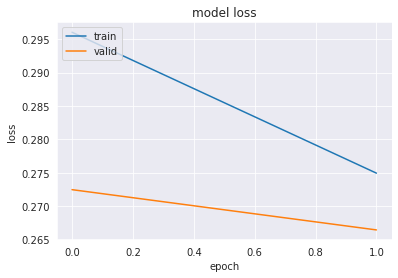

In [24]:
#%autoreload 2
((X_valid_list, y_valid_list), 
 (X_test_list, y_test_list),
 history_list, 

 #scores_valid_list,
 #scores_test_list, 

 #function_values_valid_list, 
 #function_values_test_list, 

 #polynomial_dict_valid_list,
 #polynomial_dict_test_list,

 #distrib_dict_valid_list,
 #distrib_dict_test_list,

 model_list) = interpretation_net_training(lambda_net_train_dataset_list, 
                                           lambda_net_valid_dataset_list, 
                                           lambda_net_test_dataset_list)



In [25]:
#polynomial_dict_valid_list = []
polynomial_dict_test_list = []  


for lambda_net_valid_dataset, lambda_net_test_dataset in zip(lambda_net_valid_dataset_list, lambda_net_test_dataset_list):

    #polynomial_dict_valid = {'lstsq_lambda_pred_polynomials': lambda_net_valid_dataset.lstsq_lambda_pred_polynomial_list,
    #                        'lstsq_target_polynomials': lambda_net_valid_dataset.lstsq_target_polynomial_list,
    #                        'target_polynomials': lambda_net_valid_dataset.target_polynomial_list}    

    polynomial_dict_test = {'lstsq_lambda_pred_polynomials': lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list,
                            'lstsq_target_polynomials': lambda_net_test_dataset.lstsq_target_polynomial_list,
                            'target_polynomials': lambda_net_test_dataset.target_polynomial_list}    

    #polynomial_dict_valid_list.append(polynomial_dict_valid)  
    polynomial_dict_test_list.append(polynomial_dict_test)


In [26]:
print('---------------------------------------------------------------------------------------------------------------------------')
print('------------------------------------------------------- PREDICT INET ------------------------------------------------------')

start = time.time() 

for i, (X_test, model) in enumerate(zip(X_test_list, model_list)):
    #y_test_pred = model.predict(X_test)    
    #print(model.summary())
    #print(X_test.shape)
    y_test_pred = make_inet_prediction(model, X_test, network_data=None, lambda_trained_normalized=False, inet_training_normalized=normalize_inet_data, normalization_parameter_dict=None)
    #print(y_test_pred.shape)   
    polynomial_dict_test_list[i]['inet_polynomials'] = y_test_pred


end = time.time()     
inet_train_time = (end - start) 
minutes, seconds = divmod(int(inet_train_time), 60)
hours, minutes = divmod(minutes, 60)        
print('Predict Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
print('---------------------------------------------------------------------------------------------------------------------------')

---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------- PREDICT INET ------------------------------------------------------
Predict Time: 0:00:00
---------------------------------------------------------------------------------------------------------------------------


In [27]:
if symbolic_metamodeling_poly_evaluation:
    print('-------------------------------------------------- CALCULATE METAMODEL POLY -----------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        
        metamodel_functions_test = symbolic_metamodeling_function_generation(lambda_net_test_dataset, return_expression='approx', function_metamodeling=False, force_polynomial=True)
        polynomial_dict_test_list[i]['metamodel_poly'] = metamodel_functions_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Metamodel Poly Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------') 

In [28]:
if symbolic_metamodeling_evaluation:
    print('---------------------------------------------------- CALCULATE METAMODEL --------------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        metamodel_functions_test = symbolic_metamodeling_function_generation(lambda_net_test_dataset, return_expression='approx', function_metamodeling=False, force_polynomial=False)
        polynomial_dict_test_list[i]['metamodel_functions'] = metamodel_functions_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Metamodel Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------') 

---------------------------------------------------- CALCULATE METAMODEL --------------------------------------------------


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-3)]: Done   1 tasks      | elapsed: 25.1min
[Parallel(n_jobs=-3)]: Done   2 tasks      | elapsed: 25.4min
[Parallel(n_jobs=-3)]: Done   3 tasks      | elapsed: 26.1min
[Parallel(n_jobs=-3)]: Done   4 tasks      | elapsed: 26.4min
[Parallel(n_jobs=-3)]: Done   5 tasks      | elapsed: 26.5min
[Parallel(n_jobs=-3)]: Done   6 tasks      | elapsed: 26.6min
[Parallel(n_jobs=-3)]: Done   7 tasks      | elapsed: 26.9min
[Parallel(n_jobs=-3)]: Done   8 tasks      | elapsed: 27.8min
[Parallel(n_jobs=-3)]: Done   9 tasks      | elapsed: 28.0min
[Parallel(n_jobs=-3)]: Done  10 tasks      | elapsed: 28.0min
[Parallel(n_jobs=-3)]: Done  11 tasks      | elapsed: 28.5min
[Parallel(n_jobs=-3)]: Done  12 tasks      | elapsed: 28.7min
[Parallel(n_jobs=-3)]: Done  13 tasks      | elapsed: 29.2min
[Parallel(n_jobs=-3)]: Done  14 tasks      | elapsed: 29.2min
[Parallel(n_jobs=-3)]: Done  15 tasks      | elapsed: 3

[1/(1.0039150483537*exp(0.00641799486227535*X0**3*X1**3 - 0.00127180124047327*X0**3*X2**3 - 0.0557122240201232*X0**3*X3**3 - 0.00208543443592009*X0**3*X4**3 - 0.00420571412375345*X0**3*X5**3 + 0.00655352566476454*X0**3*X6**3 + 0.00134603306094789*X0**3*X7**3 - 0.0068910464982723*X0**3*X8**3 - 0.00614079751781343*X0**3*X9**3 + 0.000718167815822416*X0**3 - 0.00150288936198132*X0**2*X1**2 + 0.000438924554105468*X0**2*X2**2 + 0.0147576781089523*X0**2*X3**2 + 0.000793776927176041*X0**2*X4**2 + 0.00112341143494966*X0**2*X5**2 - 0.00352089258592504*X0**2*X6**2 - 0.000485067608622793*X0**2*X7**2 + 0.00315410069224051*X0**2*X8**2 + 0.00185922350135366*X0**2*X9**2 - 0.00722516490488105*X0**2 - 0.0764131351945283*X0*X1 + 0.0144079769403785*X0*X2 + 0.65447963576689*X0*X3 + 0.0232431169253415*X0*X4 + 0.0493482651495351*X0*X5 - 0.0677336312268844*X0*X6 - 0.0151447904369704*X0*X7 + 0.0740540639303524*X0*X8 + 0.0709267656524815*X0*X9 + 0.000157509926087708*X0 + 0.00395879318208658*X1**3*X2**3 - 0.0021

In [29]:
if symbolic_metamodeling_function_evaluation:
    print('----------------------------------------------- CALCULATE METAMODEL FUNCTION ----------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        metamodel_functions_test = symbolic_metamodeling_function_generation(lambda_net_test_dataset, return_expression='approx', function_metamodeling=True)
        polynomial_dict_test_list[i]['metamodel_functions_no_GD'] = metamodel_functions_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Metamodel Function Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------') 

In [30]:
if symbolic_regression_evaluation:
    print('----------------------------------------- CALCULATE SYMBOLIC REGRESSION FUNCTION ------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        symbolic_regression_functions_test = symbolic_regression_function_generation(lambda_net_test_dataset)
        polynomial_dict_test_list[i]['symbolic_regression_functions'] = symbolic_regression_functions_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Symbolic Regression Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------')    

In [31]:
#%autoreload 2
if per_network_evaluation:
    print('------------------------------------------------ CALCULATE PER NETWORK POLY -----------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        per_network_poly_test = per_network_poly_generation(lambda_net_test_dataset, optimization_type='scipy')
        polynomial_dict_test_list[i]['per_network_polynomials'] = per_network_poly_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Per Network Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------')

In [32]:
print('------------------------------------------------ CALCULATE FUNCTION VALUES ------------------------------------------------')                

start = time.time() 

function_values_test_list = []
for lambda_net_test_dataset, polynomial_dict_test in zip(lambda_net_test_dataset_list, polynomial_dict_test_list):
    function_values_test = calculate_all_function_values(lambda_net_test_dataset, polynomial_dict_test)
    function_values_test_list.append(function_values_test)

end = time.time()     
inet_train_time = (end - start) 
minutes, seconds = divmod(int(inet_train_time), 60)
hours, minutes = divmod(minutes, 60)        
print('FV Calculation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
print('---------------------------------------------------------------------------------------------------------------------------')

------------------------------------------------ CALCULATE FUNCTION VALUES ------------------------------------------------
True


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.2s


True


[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  32 tasks      | elapsed:    0.2s


True


[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


False


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=10)]: Using backend SequentialBackend with 1 concurrent workers.


metamodel_poly
Exit <class 'KeyError'>
metamodel_functions
metamodel_functions_no_GD
Exit <class 'KeyError'>
symbolic_regression_functions
Exit <class 'KeyError'>
per_network_polynomials
Exit <class 'KeyError'>
FV Calculation Time: 0:02:53
---------------------------------------------------------------------------------------------------------------------------


[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:  2.7min finished


In [33]:
print('----------------------------------------------------- CALCULATE SCORES ----------------------------------------------------')                

start = time.time() 

scores_test_list = []
distrib_dict_test_list = []

for function_values_test, polynomial_dict_test in zip(function_values_test_list, polynomial_dict_test_list):
    scores_test, distrib_test = evaluate_all_predictions(function_values_test, polynomial_dict_test)
    scores_test_list.append(scores_test)
    distrib_dict_test_list.append(distrib_test)

end = time.time()     
inet_train_time = (end - start) 
minutes, seconds = divmod(int(inet_train_time), 60)
hours, minutes = divmod(minutes, 60)        
print('Score Calculation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
print('---------------------------------------------------------------------------------------------------------------------------')
print('---------------------------------------------------------------------------------------------------------------------------')         


----------------------------------------------------- CALCULATE SCORES ----------------------------------------------------
lambda_preds_VS_target_polynomials
lambda_preds_VS_lstsq_lambda_pred_polynomials
lambda_preds_VS_lstsq_target_polynomials
lambda_preds_VS_inet_polynomials
lambda_preds_VS_metamodel_functions
target_polynomials_VS_lstsq_lambda_pred_polynomials
target_polynomials_VS_lstsq_target_polynomials
target_polynomials_VS_inet_polynomials
target_polynomials_VS_metamodel_functions
lstsq_lambda_pred_polynomials_VS_lstsq_target_polynomials
lstsq_lambda_pred_polynomials_VS_inet_polynomials
lstsq_lambda_pred_polynomials_VS_metamodel_functions
lstsq_target_polynomials_VS_inet_polynomials
lstsq_target_polynomials_VS_metamodel_functions
inet_polynomials_VS_metamodel_functions
Score Calculation Time: 0:00:02
---------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------

In [34]:
identifier_type = 'epochs' if samples_list == None else 'samples'
save_results(scores_test_list, by=identifier_type)

## Evaluate Interpretation Net

In [35]:
if nas:
    for trial in history_list[-1]: 
        print(trial.summary())

In [36]:
if len(model_list) >= 1:
    print(model_list[-1].summary())
    print(model_list[-1].get_config())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 601)]        0                                            
__________________________________________________________________________________________________
hidden1_512 (Dense)             (None, 512)          308224      input[0][0]                      
__________________________________________________________________________________________________
activation1_relu (Activation)   (None, 512)          0           hidden1_512[0][0]                
__________________________________________________________________________________________________
dropout1_0.25 (Dropout)         (None, 512)          0           activation1_relu[0][0]           
______________________________________________________________________________________________

In [37]:
if evaluate_with_real_function:
    keys = ['inetPoly_VS_targetPoly_test', 'perNetworkPoly_VS_targetPoly_test', 'predLambda_VS_targetPoly_test', 'lstsqLambda_VS_targetPoly_test', 'lstsqTarget_VS_targetPoly_test']
else:
    keys = ['inetPoly_VS_predLambda_test', 'inetPoly_VS_lstsqLambda_test', 'perNetworkPoly_VS_predLambda_test', 'perNetworkPoly_VS_lstsqLambda_test', 'lstsqLambda_VS_predLambda_test', 'predLambda_VS_targetPoly_test']

In [38]:
scores_test_list[-1]

MAE  RMSE   MAPE  \
lambda_preds_VS_target_polynomials                   NaN   NaN    NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials        NaN   NaN    NaN   
lambda_preds_VS_lstsq_target_polynomials             NaN   NaN    NaN   
lambda_preds_VS_inet_polynomials                     NaN   NaN    NaN   
lambda_preds_VS_metamodel_functions                  NaN   NaN    NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.102 0.144  9.534   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000  0.000   
target_polynomials_VS_inet_polynomials             0.124 0.176 10.796   
target_polynomials_VS_metamodel_functions            NaN   NaN    NaN   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.102 0.144  1.459   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.155 0.213  7.266   
lstsq_lambda_pred_polynomials_VS_metamodel_func...   NaN   NaN    NaN   
lstsq_target_polynomials_VS_inet_polynomials       0.124 0.176 10.796   
lstsq_target_polynomials_VS_metamodel_functions      NaN   NaN    NaN   
inet_polynomials_VS_metamodel_functions              NaN   NaN    NaN   

                                                    Accuracy  \
lambda_preds_VS_target_polynomials                       NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials            NaN   
lambda_preds_VS_lstsq_target_polynomials                 NaN   
lambda_preds_VS_inet_polynomials                         NaN   
lambda_preds_VS_metamodel_functions                      NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom...     0.360   
target_polynomials_VS_lstsq_target_polynomials         1.000   
target_polynomials_VS_inet_polynomials                 0.277   
target_polynomials_VS_metamodel_functions                NaN   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...     0.360   
lstsq_lambda_pred_polynomials_VS_inet_polynomials      0.222   
lstsq_lambda_pred_polynomials_VS_metamodel_func...       NaN   
lstsq_target_polynomials_VS_inet_polynomials           0.277   
lstsq_target_polynomials_VS_metamodel_functions          NaN   
inet_polynomials_VS_metamodel_functions                  NaN   

                                                    Accuracy Multilabel  \
lambda_preds_VS_target_polynomials                                  NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials                       NaN   
lambda_preds_VS_lstsq_target_polynomials                            NaN   
lambda_preds_VS_inet_polynomials                                    NaN   
lambda_preds_VS_metamodel_functions                                 NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom...                0.000   
target_polynomials_VS_lstsq_target_polynomials                    1.000   
target_polynomials_VS_inet_polynomials                            0.000   
target_polynomials_VS_metamodel_functions                           NaN   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...                0.000   
lstsq_lambda_pred_polynomials_VS_inet_polynomials                 0.000   
lstsq_lambda_pred_polynomials_VS_metamodel_func...                  NaN   
lstsq_target_polynomials_VS_inet_polynomials                      0.000   
lstsq_target_polynomials_VS_metamodel_functions                     NaN   
inet_polynomials_VS_metamodel_functions                             NaN   

                                                    MAE FV  RMSE FV  MAPE FV  \
lambda_preds_VS_target_polynomials                   0.025    0.034    2.350   
lambda_preds_VS_lstsq_lambda_pred_polynomials        0.032    0.042    2.478   
lambda_preds_VS_lstsq_target_polynomials             0.025    0.034    2.350   
lambda_preds_VS_inet_polynomials                     0.404    0.494    3.977   
lambda_preds_VS_metamodel_functions                  0.564    0.609   27.524   
target_polynomials_VS_lstsq_lambda_pred_polynom...   0.030    0.040    0.695   
target_polynomials_VS_lstsq_target_polynomials       0.000    0.000    0.000   
target_polynomials

In [56]:
distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_metamodel_functions'].values

array([0.4315213 , 0.4382647 , 0.64183384, 0.24760015,        nan,
       0.42360958, 0.80831134, 0.30288637, 0.49151474, 0.47832417,
       0.47795206,        nan, 0.64044416, 0.35870945, 0.78142285,
              nan, 1.7069447 ,        nan, 0.4006022 , 0.5194924 ,
       0.7141789 , 0.7177072 , 0.5886794 , 0.67889905, 0.980174  ,
       0.7516393 , 0.6204839 , 0.6277507 , 0.73204005, 0.6945248 ,
       0.2755567 , 0.69686913, 1.609203  , 0.49919385, 0.7622246 ,
       0.62538236,        nan,        nan,        nan, 0.95271546,
       0.5608947 , 0.6325294 , 0.7931054 , 0.32974452, 0.5992025 ,
       0.2796427 , 0.34658372, 0.6078003 , 0.48582178, 0.38274488,
       0.50865155, 0.60862136, 0.36224163, 0.5721488 , 0.5365945 ,
       0.27888057, 0.4663083 , 0.22702412, 0.47849718, 0.21778081,
       0.71645   , 0.54611516, 0.35670796, 0.30249956, 0.75970846,
       0.41912436, 0.2948545 , 0.5522152 , 0.20927769, 0.9286998 ,
       0.2521149 ,        nan,        nan, 0.32574937, 0.48308

In [57]:
distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_metamodel_functions'].values

array([ -2.22026165,  -2.57022192,  -2.3196109 ,  -0.95835289,
                nan,  -2.28042424,  -3.08459421,   0.33736169,
        -1.75697405,  -1.45552695,  -1.07571729,          nan,
        -3.61014458,  -0.02952706, -11.10919835,          nan,
       -23.11582647,          nan,  -0.24019257,  -3.25407378,
        -3.36895015,  -4.65937374,  -3.2490516 ,  -6.13708961,
        -6.06517456,  -3.74767312, -10.44152805,  -5.94097069,
        -3.16450532,  -2.06225549,   0.35657051,  -7.48197848,
       -14.51294787,  -1.77115408,  -3.76068535,  -4.26005   ,
                nan,          nan,          nan,  -6.04798355,
        -2.72701703,  -5.05288053,  -5.83405376,  -0.58170597,
        -2.69849218,   0.26821538,  -1.19610049,  -8.69444743,
        -5.97713978,  -0.4426831 ,  -2.68472071,  -4.12306932,
        -1.83107611,  -2.32045393,  -4.22628254,   0.03300938,
        -1.27167826,  -0.45609691,  -0.48157199,   0.0528735 ,
        -4.42878093,  -5.52086081,  -0.64536485,  -0.82

In [39]:
distrib_dict_test_list[-1]['MAE']

L-0   L-1   L-2   L-3  \
lambda_preds_VS_target_polynomials                 0.028 0.021 0.033 0.019   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.031 0.031 0.035 0.025   
lambda_preds_VS_lstsq_target_polynomials           0.028 0.021 0.033 0.019   
lambda_preds_VS_inet_polynomials                   0.217 0.198 0.390 0.186   
lambda_preds_VS_metamodel_functions                0.432 0.438 0.642 0.248   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.029 0.028 0.037 0.021   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000 0.000 0.000   
target_polynomials_VS_inet_polynomials             0.215 0.197 0.396 0.187   
target_polynomials_VS_metamodel_functions          0.434 0.440 0.649 0.252   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.029 0.028 0.037 0.021   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.218 0.199 0.389 0.186   
lstsq_lambda_pred_polynomials_VS_metamodel_func... 0.431 0.438 0.641 0.249   
lstsq_target_polynomials_VS_inet_polynomials       0.215 0.197 0.396 0.187   
lstsq_target_polynomials_VS_metamodel_functions    0.434 0.440 0.649 0.252   
inet_polynomials_VS_metamodel_functions            0.425 0.442 0.358 0.398   

                                                     L-4   L-5   L-6   L-7  \
lambda_preds_VS_target_polynomials                 0.021 0.019 0.023 0.026   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.028 0.025 0.029 0.035   
lambda_preds_VS_lstsq_target_polynomials           0.021 0.019 0.023 0.026   
lambda_preds_VS_inet_polynomials                   0.373 0.242 0.619 0.370   
lambda_preds_VS_metamodel_functions                  NaN 0.424 0.808 0.303   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.024 0.024 0.026 0.032   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000 0.000 0.000   
target_polynomials_VS_inet_polynomials             0.378 0.243 0.620 0.369   
target_polynomials_VS_metamodel_functions            NaN 0.426 0.810 0.302   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.024 0.024 0.026 0.032   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.372 0.241 0.621 0.369   
lstsq_lambda_pred_polynomials_VS_metamodel_func...   NaN 0.423 0.811 0.303   
lstsq_target_polynomials_VS_inet_polynomials       0.378 0.243 0.620 0.369   
lstsq_target_polynomials_VS_metamodel_functions      NaN 0.426 0.810 0.302   
inet_polynomials_VS_metamodel_functions              NaN 0.356 0.239 0.214   

                                                     L-8   L-9  L-10  L-11  \
lambda_preds_VS_target_polynomials                 0.027 0.032 0.026 0.030   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.035 0.042 0.035 0.038   
lambda_preds_VS_lstsq_target_polynomials           0.027 0.032 0.026 0.030   
lambda_preds_VS_inet_polynomials                   0.293 0.274 0.316 0.656   
lambda_preds_VS_metamodel_functions                0.492 0.478 0.478   NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.033 0.039 0.033 0.037   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000 0.000 0.000   
target_polynomials_VS_inet_polynomials             0.290 0.274 0.318 0.656   
target_polynomials_VS_metamodel_functions          0.492 0.480 0.483   NaN   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.033 0.039 0.033 0.037   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.292 0.279 0.320 0.654   
lstsq_lambda_pred_polynomials_VS_metamodel_func... 0.489 0.477 0.478   NaN   
lstsq_target_polynomials_VS_inet_polynomials       0.290 0.274 0.318 0.656   
lstsq_target_polynomials_VS_metamodel_functions    0.492 0.480 0.483   NaN   
inet_polynomials_VS_metamodel_functions            0.360 0.388 0.427   NaN   

                                                    L-12  L-13  L-14  L-15  \
lambda_preds_VS_target_polynomials                 0.022 0.025 0.020 0.027   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.030 0.034 0.027 0.037   
lambda_preds_VS_lstsq_target_polynomials           0.022 0.025 0.020 0.0

In [40]:
distrib_dict_test_list[-1]['R2']

L-0     L-1     L-2  \
lambda_preds_VS_target_polynomials                   0.982   0.988   0.988   
lambda_preds_VS_lstsq_lambda_pred_polynomials        0.976   0.974   0.986   
lambda_preds_VS_lstsq_target_polynomials             0.982   0.988   0.988   
lambda_preds_VS_inet_polynomials                    -0.042  -0.019  -0.664   
lambda_preds_VS_metamodel_functions                 -2.220  -2.570  -2.320   
target_polynomials_VS_lstsq_lambda_pred_polynom...   0.979   0.977   0.984   
target_polynomials_VS_lstsq_target_polynomials       1.000   1.000   1.000   
target_polynomials_VS_inet_polynomials              -0.042  -0.023  -0.662   
target_polynomials_VS_metamodel_functions           -2.195  -2.549  -2.268   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...   0.980   0.978   0.984   
lstsq_lambda_pred_polynomials_VS_inet_polynomials   -0.039  -0.011  -0.661   
lstsq_lambda_pred_polynomials_VS_metamodel_func...  -2.125  -2.456  -2.327   
lstsq_target_polynomials_VS_inet_polynomials        -0.042  -0.023  -0.662   
lstsq_target_polynomials_VS_metamodel_functions     -2.195  -2.549  -2.268   
inet_polynomials_VS_metamodel_functions            -51.481 -41.920 -20.466   

                                                      L-3    L-4    L-5  \
lambda_preds_VS_target_polynomials                  0.984  0.996  0.989   
lambda_preds_VS_lstsq_lambda_pred_polynomials       0.974  0.993  0.983   
lambda_preds_VS_lstsq_target_polynomials            0.984  0.996  0.989   
lambda_preds_VS_inet_polynomials                   -0.277 -0.256 -0.616   
lambda_preds_VS_metamodel_functions                -0.958    NaN -2.280   
target_polynomials_VS_lstsq_lambda_pred_polynom...  0.980  0.994  0.984   
target_polynomials_VS_lstsq_target_polynomials      1.000  1.000  1.000   
target_polynomials_VS_inet_polynomials             -0.243 -0.263 -0.592   
target_polynomials_VS_metamodel_functions          -0.887    NaN -2.170   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...  0.980  0.994  0.984   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  -0.271 -0.244 -0.614   
lstsq_lambda_pred_polynomials_VS_metamodel_func... -0.951    NaN -2.265   
lstsq_target_polynomials_VS_inet_polynomials       -0.243 -0.263 -0.592   
lstsq_target_polynomials_VS_metamodel_functions    -0.887    NaN -2.170   
inet_polynomials_VS_metamodel_functions            -9.818    NaN -8.392   

                                                      L-6    L-7     L-8  \
lambda_preds_VS_target_polynomials                  0.995  0.994   0.989   
lambda_preds_VS_lstsq_lambda_pred_polynomials       0.992  0.990   0.981   
lambda_preds_VS_lstsq_target_polynomials            0.995  0.994   0.989   
lambda_preds_VS_inet_polynomials                   -2.063 -0.038  -0.312   
lambda_preds_VS_metamodel_functions                -3.085  0.337  -1.757   
target_polynomials_VS_lstsq_lambda_pred_polynom...  0.994  0.991   0.982   
target_polynomials_VS_lstsq_target_polynomials      1.000  1.000   1.000   
target_polynomials_VS_inet_polynomials             -2.058 -0.043  -0.306   
target_polynomials_VS_metamodel_functions          -3.073  0.338  -1.713   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...  0.994  0.991   0.982   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  -2.053 -0.029  -0.316   
lstsq_lambda_pred_polynomials_VS_metamodel_func... -3.065  0.331  -1.720   
lstsq_target_polynomials_VS_inet_polynomials       -2.058 -0.043  -0.306   
lstsq_target_polynomials_VS_metamodel_functions    -3.073  0.338  -1.713   
inet_polynomials_VS_metamodel_functions            -6.755 -0.533 -14.133   

                                                       L-9    L-10   L-11  \
lambda_preds_VS_target_polynomials                   0.984   0.991  0.992   
lambda_preds_VS_lstsq_lambda_pred_polynomials        0.973   0.984  0.986   
lambda_preds_VS_lstsq_target_polynomials             0.984   0.991  0.992   
lambda_preds_VS_inet_polynomials                    -0.074  -0.104 -2.256   
lam

In [41]:
index_min = int(np.argmin(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials']))

print(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][index_min])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

0.9546813245712352


0.125863489025821*a**3 + 0.167225602149968*a**2*b - 0.0404769493626459*a**2*c - 0.113565416100977*a**2*d - 0.158991706377988*a**2*e + 0.126219555933027*a**2*f - 0.0425971402259991*a**2*g + 0.054186383884055*a**2*h + 0.0258031503451514*a**2*i + 0.0214118037941958*a**2*j - 0.191018628549284*a**2 + 0.162979031352693*a*b**2 - 0.158202929429091*a*b*c + 0.0053941240619083*a*b*d + 0.0369669289644712*a*b*e - 0.788149487750378*a*b*f - 0.271610028809142*a*b*g - 0.193921180233841*a*b*h + 0.178300934428919*a*b*i + 0.0498171018904865*a*b*j - 0.225914161752037*a*b - 0.225638430812219*a*c**2 + 0.0331376257984978*a*c*d - 0.0533775914907837*a*c*e - 0.0133152908098542*a*c*f - 0.081929831946161*a*c*g + 0.0186491378025198*a*c*h + 0.0603473898986169*a*c*i - 0.200093618216442*a*c*j + 0.444977262054746*a*c - 0.029829226500381*a*d**2 - 0.0901829208504292*a*d*e - 0.103457326243842*a*d*f + 0.0931802098513107*a*d*g - 0.092381481463573*a*d*h + 0.102898563996896*a*d*i - 0.0149858357386436*a*d*j + 0.21759054829264*

In [42]:
r2_values_inet = distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_inet_polynomials']
print('Mean: ' + str(np.mean(r2_values_inet)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_inet = r2_values_inet[r2_values_inet>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_inet)) + ' (' + str(r2_values_positive_inet.shape[0]) + ' Samples)')



Mean: -1.4762918473788815 (100 Samples)
Mean (only positive): 0.10101928835486929 (9 Samples)


In [43]:
r2_values_lstsq_lambda = distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials']
print('Mean: ' + str(np.mean(r2_values_lstsq_lambda)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_lstsq_lambda = r2_values_lstsq_lambda[r2_values_lstsq_lambda>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_lstsq_lambda)) + ' (' + str(r2_values_positive_lstsq_lambda.shape[0]) + ' Samples)')



Mean: 0.9826193014459089 (100 Samples)
Mean (only positive): 0.9826193014459089 (100 Samples)


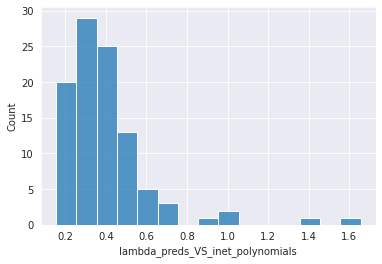

In [44]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'] < 50], binwidth=0.1)
#p.set(xlim=(0, 20))


[(0.0, 1.0)]

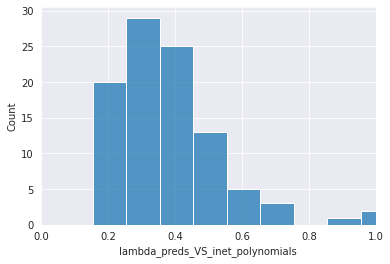

In [45]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'] < 50], binwidth=0.1)
p.set(xlim=(0, 1))


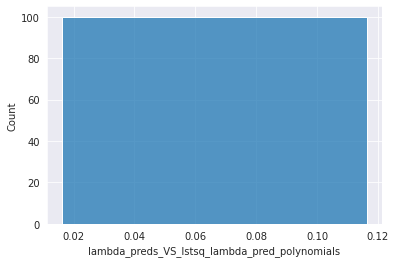

In [46]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'] < 50], binwidth=0.1)
#p.set(xlim=(0, 20))


[(0.0, 1.0)]

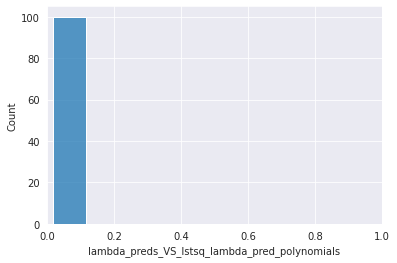

In [47]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'] < 50], binwidth=0.1)
p.set(xlim=(0, 1))


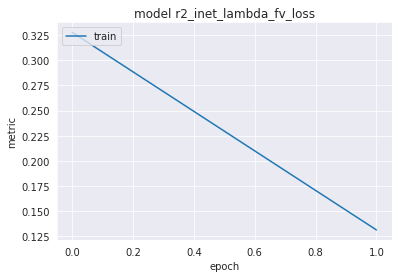

In [48]:
if not nas:
    history = history_list[-1]

    plt.plot(history[list(history.keys())[1]])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]]) 
    plt.title('model ' + list(history.keys())[1])
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/metric_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


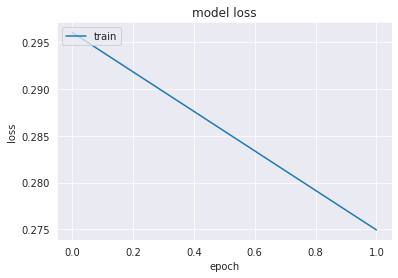

In [49]:
if not nas:
    history = history_list[-1]

    plt.plot(history['loss'])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/loss_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

### Generate Comparison Plots

In [50]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [51]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [52]:
if len(scores_test_list) > 1:
    plot_metric_list = ['R2 FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list, ylim=(-5, 1))

#### Generate and Analyze Predictions for Random Function

In [53]:
index = 6

custom_representation_keys_fixed = ['target_polynomials', 'lstsq_target_polynomials', 'lstsq_lambda_pred_polynomials', 'lstsq_lambda_pred_polynomials']
custom_representation_keys_dynamic = ['inet_polynomials', 'per_network_polynomials']
sympy_representation_keys = ['metamodel_functions']


print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')

for key in polynomial_dict_test_list[-1].keys():
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print(key)
    if key in custom_representation_keys_fixed:
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], force_complete_poly_representation=True, round_digits=4)
        print(polynomial_dict_test_list[-1][key][index])
    elif key in custom_representation_keys_dynamic:
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], round_digits=4)
        print(polynomial_dict_test_list[-1][key][index])
    else:
        display(polynomial_dict_test_list[-1][key][index])

print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
lstsq_lambda_pred_polynomials


-0.0068*a**3 - 0.0518*a**2*b + 0.1131*a**2*c - 0.0431*a**2*d + 0.0488*a**2*e - 0.0795*a**2*f - 0.013*a**2*g - 0.1041*a**2*h - 0.2064*a**2*i + 0.1594*a**2*j + 0.1333*a**2 - 0.1899*a*b**2 + 0.0654*a*b*c + 0.0728*a*b*d - 0.104*a*b*e + 0.0227*a*b*f - 0.109*a*b*g - 0.0558*a*b*h - 0.1187*a*b*i + 0.0018*a*b*j + 0.3792*a*b - 0.0869*a*c**2 - 0.1972*a*c*d + 0.0423*a*c*e - 0.1098*a*c*f + 0.0547*a*c*g + 0.0464*a*c*h + 0.0829*a*c*i - 0.0772*a*c*j + 0.0152*a*c - 0.0074*a*d**2 - 0.0517*a*d*e + 0.0958*a*d*f + 0.1149*a*d*g + 0.0627*a*d*h + 0.0094*a*d*i - 0.0037*a*d*j - 0.006*a*d + 0.0384*a*e**2 - 0.0161*a*e*f + 0.0879*a*e*g + 0.0134*a*e*h + 0.0087*a*e*i + 0.0037*a*e*j - 0.0629*a*e - 0.0705*a*f**2 - 0.299*a*f*g + 0.0131*a*f*h + 0.0177*a*f*i + 0.0786*a*f*j + 0.2375*a*f - 0.0139*a*g**2 - 0.1619*a*g*h - 0.0305*a*g*i + 0.1109*a*g*j + 0.1693*a*g - 0.0708*a*h**2 - 0.0501*a*h*i + 0.1164*a*h*j + 0.1638*a*h + 0.0249*a*i**2 + 0.0112*a*i*j + 0.2166*a*i - 0.0338*a*j**2 - 0.2465*a*j - 0.273*a + 0.0124*b**3 + 0.1658*

[-6.84428086e-03 -5.18379784e-02  1.13148275e-01 -4.30518591e-02
  4.88309154e-02 -7.94681887e-02 -1.30164586e-02 -1.04111546e-01
 -2.06390536e-01  1.59393685e-01  1.33338757e-01 -1.89920957e-01
  6.54389787e-02  7.28450276e-02 -1.03965253e-01  2.27155891e-02
 -1.08984087e-01 -5.57720018e-02 -1.18697129e-01  1.82091429e-03
  3.79196995e-01 -8.68918549e-02 -1.97212690e-01  4.23243348e-02
 -1.09819362e-01  5.46984852e-02  4.63987202e-02  8.29089337e-02
 -7.71521725e-02  1.51580552e-02 -7.35794684e-03 -5.16588886e-02
  9.57636440e-02  1.14935900e-01  6.27070362e-02  9.36385277e-03
 -3.67323949e-03 -6.02584314e-03  3.84225630e-02 -1.60666838e-02
  8.79288718e-02  1.34351978e-02  8.74167261e-03  3.71388660e-03
 -6.28629911e-02 -7.04802375e-02 -2.98989182e-01  1.31397283e-02
  1.76570503e-02  7.86335147e-02  2.37519560e-01 -1.38599951e-02
 -1.61852074e-01 -3.04667395e-02  1.10895468e-01  1.69280971e-01
 -7.08122941e-02 -5.00972569e-02  1.16423275e-01  1.63798568e-01
  2.49087779e-02  1.12116

-0.7363*b*c*g + 0.4014*b*d*e + 0.0106*b*e*i + 0.7959*c**3 - 0.402*c*d*j - 0.7074*d**3 - 0.7786*d*e - 0.8852*e**2*j + 0.264*e*f*i - 0.3292*i**2*j

[ 9.91288494e-08 -4.51160077e-08  5.42503842e-08  6.57433092e-08
  1.73589973e-08  8.08597388e-09 -4.19800867e-08  1.27002990e-08
 -3.04812058e-08  4.41062619e-08 -1.72523425e-07  5.19089845e-08
  7.24383298e-08 -3.48997470e-09 -8.03041782e-09  5.78065019e-08
 -4.29105371e-08 -5.98077237e-08  2.16330465e-09  6.31253263e-08
 -4.84439444e-08  8.05002998e-09 -2.51340321e-08 -4.60637500e-10
 -4.49773474e-08 -5.35074500e-08 -1.98470198e-08  2.76926035e-09
  5.56594496e-08 -5.82014502e-08 -3.71467306e-08 -2.79424883e-09
  6.75142055e-08 -1.17954802e-08  9.89822630e-08 -6.59365057e-08
 -4.29277767e-08 -2.87228476e-08  1.88770559e-08  8.78829265e-08
 -2.71365728e-08 -2.24341333e-08  1.91273676e-08 -1.00451324e-08
 -6.48421168e-08  4.53018778e-08  8.78153698e-09 -3.77938526e-08
 -3.54618979e-08 -1.75380884e-08 -8.22314278e-08 -4.50094717e-08
  5.33161954e-08 -1.73397684e-08 -1.40391720e-08  1.41882360e-07
 -3.81856263e-09 -1.67232005e-08  5.02191177e-09  1.41130100e-08
  2.11117196e-08 -2.24321

-0.7363*b*c*g + 0.4014*b*d*e + 0.0106*b*e*i + 0.7959*c**3 - 0.402*c*d*j - 0.7074*d**3 - 0.7786*d*e - 0.8852*e**2*j + 0.264*e*f*i - 0.3292*i**2*j

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         -0.73631426  0.          0.          0.
  0.          0.          0.40141136  0.          0.          0.
  0.          0.         

-0.0255999993532896*a*f + 0.155499994754791*b**3 - 0.0513000003993511*c*e*j - 0.0483000017702579*d*h*j + 0.197200000286102*d*i**2 + 0.211199998855591*e*i + 0.175799995660782*g**2*h + 0.0754000023007393*g**2*j + 0.0107000004500151*h*i*j + 0.0793000012636185*j**2

[0.17584348 0.19718407 0.01072846 ... 0.00374581 0.00311894 0.00421545]
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
metamodel_functions


1/(0.902079109465808*exp(0.000951808065374987*X0**3*X1**3 + 0.00478019914006639*X0**3*X2**3 - 0.00926013493320046*X0**3*X3**3 - 0.013054178563803*X0**3*X4**3 - 0.00472486657828481*X0**3*X5**3 + 0.00467010507960893*X0**3*X6**3 - 0.00614947755859781*X0**3*X7**3 + 0.0033264946371142*X0**3*X8**3 + 0.011348372502498*X0**3*X9**3 + 2.1422784209917e-16*X0**3 - 0.000343382843395272*X0**2*X1**2 - 0.0027421759280158*X0**2*X2**2 + 0.00029275495000706*X0**2*X3**2 + 0.00314734963851756*X0**2*X4**2 + 0.00198329982664665*X0**2*X5**2 - 0.00160579925286448*X0**2*X6**2 + 0.00219922890152336*X0**2*X7**2 - 0.00133156382818274*X0**2*X8**2 - 0.00274363061064537*X0**2*X9**2 + 7.21603754221801e-16*X0**2 - 0.010707101039224*X0*X1 - 0.0485123885039588*X0*X2 + 0.120041730479483*X0*X3 + 0.154925534315601*X0*X4 + 0.0517098710481815*X0*X5 - 0.0529358510381603*X0*X6 + 0.0692798720950003*X0*X7 - 0.0367343149184949*X0*X8 - 0.134666476956617*X0*X9 - 8.51198221300882e-17*X0 - 0.011789635061281*X1**3*X2**3 + 0.00479036905

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


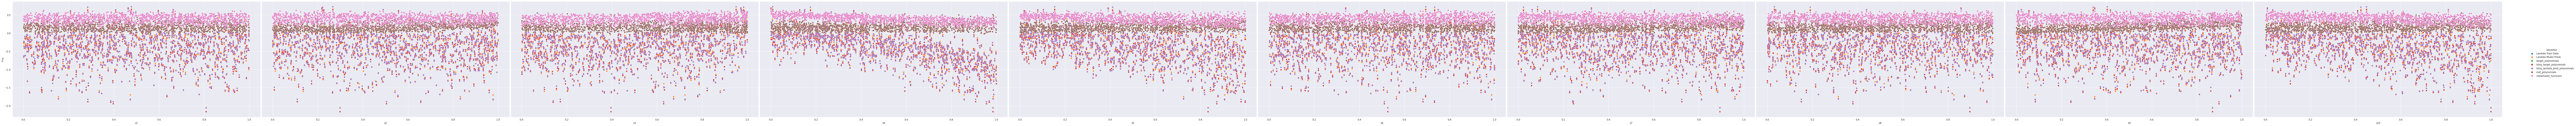

In [54]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=1)

In [55]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=2)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f8c2927ba60> (for post_execute):


KeyboardInterrupt: 

In [ ]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=3)

In [ ]:
STOP

# BENCHMARK (RANDOM GUESS) EVALUATION

In [ ]:
list_of_random_polynomials = np.random.uniform(low=-10, high=10, size=(len(lambda_net_test_dataset_list[-1]), sparsity))

In [ ]:
true_fv_test = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

In [ ]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(lambda_net_test_dataset_list[-1].target_polynomial_list, list_of_random_polynomials), 4)))

In [ ]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [ ]:
true_fv_train = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

In [ ]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

In [ ]:
%%script false --no-raise-error

base_model = generate_base_model()
random_evaluation_dataset = np.random.uniform(low=x_min, high=x_max, size=(random_evaluation_dataset_size, n))
#random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)


loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

#X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))


seed_in_inet_training = False

loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))

seed_in_inet_training = True



In [ ]:
lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
current_jobs = 1

lr=0.5
max_steps = 100
early_stopping=10
restarts=2
per_network_dataset_size = 500

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

if n_jobs != -1:
    n_jobs_per_network = min(n_jobs, os.cpu_count() // current_jobs)
else: 
    n_jobs_per_network = os.cpu_count() // current_jobs - 1

printing = True if n_jobs_per_network == 1 else False


lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
if evaluate_with_real_function: #target polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.target_polynomial_list)
else: #lstsq lambda pred polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list)


config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }


lambda_network_weights = lambda_network_weights_list[0]
poly_representation = poly_representation_list[0]



per_network_poly_optimization_tf(per_network_dataset_size, 
                                lambda_network_weights, 
                                  list_of_monomial_identifiers_numbers, 
                                  config, 
                                  lr=lr, 
                                  max_steps = max_steps, 
                                  early_stopping=early_stopping, 
                                  restarts=restarts, 
                                  printing=True)


# Evaluate Real Dataset


##  Auto MPG-Dataset

In [ ]:
interpretation_possible_autoMPG = False
print_head_autoMPG = None

url_autoMPG = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names_autoMPG = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset_autoMPG = pd.read_csv(url_autoMPG, names=column_names_autoMPG,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset_autoMPG = raw_dataset_autoMPG.dropna()

dataset_autoMPG['Origin'] = dataset_autoMPG['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset_autoMPG = pd.get_dummies(dataset_autoMPG, columns=['Origin'], prefix='', prefix_sep='')


features_autoMPG = dataset_autoMPG.copy()

labels_autoMPG = features_autoMPG.pop('MPG')

features_autoMPG_normalized = (features_autoMPG-features_autoMPG.min())/(features_autoMPG.max()-features_autoMPG.min())

#labels_autoMPG = (labels_autoMPG-labels_autoMPG.min())/(labels_autoMPG.max()-labels_autoMPG.min())


if features_autoMPG_normalized.shape[1] >= n:
    if n == 1:
        features_autoMPG_model = features_autoMPG_normalized[['Horsepower']]
    elif n == features_autoMPG_normalized.shape[1]:
        features_autoMPG_model = features_autoMPG_normalized
    else:
        features_autoMPG_model = features_autoMPG_normalized.sample(n=n, axis='columns')
        
    print_head_autoMPG = features_autoMPG_model.head()
    interpretation_possible_autoMPG = True

print_head_autoMPG

In [ ]:
#%load_ext autoreload

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    ((lambda_index_autoMPG, 
     current_seed_autoMPG, 
     polynomial_autoMPG, 
     polynomial_lstsq_pred_list_autoMPG, 
     polynomial_lstsq_true_list_autoMPG), 
    scores_list_autoMPG, 
    pred_list_autoMPG, 
    history_autoMPG, 
    model_autoMPG) = train_nn(lambda_index=0, 
                              X_data_lambda=features_autoMPG_model.values, 
                              y_data_real_lambda=labels_autoMPG.values, 
                              polynomial=None, 
                              seed_list=[RANDOM_SEED], 
                              callbacks=[PlotLossesKerasTF()], 
                              return_history=True, 
                              each_epochs_save=None, 
                              printing=False, 
                              return_model=True)
    
    polynomial_lstsq_pred_autoMPG = polynomial_lstsq_pred_list_autoMPG[-1]

In [ ]:
if interpretation_possible_autoMPG and n==1:
    x = tf.linspace(0.0, 250, 251)
    y = model_autoMPG.predict(x)

    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [ ]:
config = {
        'n': n,
        'd': d,
        'inet_loss': inet_loss,
        'sparsity': sparsity,
        'lambda_network_layers': lambda_network_layers,
        'interpretation_net_output_shape': interpretation_net_output_shape,
        'RANDOM_SEED': RANDOM_SEED,
        'nas': nas,
        'number_of_lambda_weights': number_of_lambda_weights,
        'interpretation_net_output_monomials': interpretation_net_output_monomials,
        'fixed_initialization_lambda_training': fixed_initialization_lambda_training,
        'dropout': dropout,
        'lambda_network_layers': lambda_network_layers,
        'optimizer_lambda': optimizer_lambda,
        'loss_lambda': loss_lambda,        
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }

weights_autoMPG = model_autoMPG.get_weights()

weights_flat_autoMPG = []
for layer_weights, biases in pairwise(weights_autoMPG):    #clf.get_weights()
    for neuron in layer_weights:
        for weight in neuron:
            weights_flat_autoMPG.append(weight)
    for bias in biases:
        weights_flat_autoMPG.append(bias)
        
weights_flat_autoMPG = np.array(weights_flat_autoMPG)


x = pred_list_autoMPG['X_test_lambda']
y = pred_list_autoMPG['y_test_real_lambda']

y_model_autoMPG = model_autoMPG.predict(x)




In [ ]:
if interpretation_possible_autoMPG:
    y_polynomial_lstsq_pred_autoMPG = calculate_function_values_from_polynomial(polynomial_lstsq_pred_autoMPG, x, force_complete_poly_representation=True)

    mae_model_polynomial_lstsq_pred_autoMPGy = mean_absolute_error(y_model_autoMPG, y_polynomial_lstsq_pred_autoMPG)
    mae_data_polynomial_lstsq_pred_autoMPG = mean_absolute_error(y, y_polynomial_lstsq_pred_autoMPG)

    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQt Poly:')
    print_polynomial_from_coefficients(y_polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('MAE Model: ', mae_model_polynomial_lstsq_pred_autoMPGy)
    print('MAE Data: ', mae_data_polynomial_lstsq_pred_autoMPG)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    interpretation_net = model_list[-1]
    
    start = time.time() 
    
    #interpretation_net_poly = interpretation_net.predict(np.array([weights_flat_autoMPG]))[0]
    interpretation_net_poly = make_inet_prediction(interpretation_net, weights_flat_autoMPG, network_data=None, lambda_trained_normalized=False, inet_training_normalized=normalize_inet_data, normalization_parameter_dict=None)
    
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_interpretation_net_poly = calculate_function_values_from_polynomial(interpretation_net_poly, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_interpretation_net_poly)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_interpretation_net_poly)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)    
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG:

    start = time.time() 
    
    if False:
        per_network_hyperparams = {
            'optimizer':  'Powell',
            'jac': 'fprime',
            'max_steps': 5000,#100,
            'restarts': 3,
            'per_network_dataset_size': 500,
        }      
        
        per_network_function =  per_network_poly_optimization_scipy(per_network_dataset_size, 
                                                                  weights_flat_autoMPG, 
                                                                  list_of_monomial_identifiers_numbers, 
                                                                  config, 
                                                                  optimizer = per_network_hyperparams['optimizer'],
                                                                  jac = per_network_hyperparams['jac'],
                                                                  max_steps = per_network_hyperparams['max_steps'], 
                                                                  restarts=per_network_hyperparams['restarts'], 
                                                                  printing=True,
                                                                  return_error=False)
    else:
        per_network_hyperparams = {
            'optimizer': tf.keras.optimizers.RMSprop,
            'lr': 0.02,
            'max_steps': 500,
            'early_stopping': 10,
            'restarts': 3,
            'per_network_dataset_size': 5000,
        }   
        
        per_network_function =  per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                              weights_flat_autoMPG, 
                                                              list_of_monomial_identifiers_numbers, 
                                                              config, 
                                                              optimizer = per_network_hyperparams['optimizer'],
                                                              lr=per_network_hyperparams['lr'], 
                                                              max_steps = per_network_hyperparams['max_steps'], 
                                                              early_stopping=per_network_hyperparams['early_stopping'], 
                                                              restarts=per_network_hyperparams['restarts'], 
                                                              printing=True,
                                                              return_error=False)
            
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)  
    
    y_per_network_function = calculate_function_values_from_polynomial(per_network_function, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_per_network_function)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_per_network_function)    
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)       
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
#%load_ext autoreload

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    
    symbolic_regression_hyperparams = {
        'dataset_size': 500,
    }

    start = time.time() 
    
    symbolic_regression_function =  symbolic_regression(model_autoMPG, 
                                                      config,
                                                      symbolic_regression_hyperparams,
                                                      #printing = True,
                                                      return_error = False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    variable_names = ['X' + str(i) for i in range(n)]
    
    y_symbolic_regression_function = calculate_function_values_from_sympy(symbolic_regression_function, x, variable_names=variable_names)
    
    mae_model_symbolic_regression_function = mean_absolute_error(y_model_autoMPG, y_symbolic_regression_function)
    mae_data_symbolic_regression_function = mean_absolute_error(y, y_symbolic_regression_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Poly:')    
    display(symbolic_regression_function)
    print('MAE Model: ', mae_model_symbolic_regression_function)
    print('MAE Data: ', mae_data_symbolic_regression_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG and True:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = False,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function = calculate_function_values_from_sympy(metamodel_function, x)
    
    mae_model_metamodel_function = mean_absolute_error(y_model_autoMPG, y_metamodel_function)
    mae_data_metamodel_function = mean_absolute_error(y, y_metamodel_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')    
    display(metamodel_function)
    print('MAE Model: ', mae_model_metamodel_function)
    print('MAE Data: ', mae_data_metamodel_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG and False:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function_basic =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = True,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function_basic = calculate_function_values_from_sympy(metamodel_function_basic, x)
    
    mae_metamodel_function_basic = mean_absolute_error(y_model_autoMPG, y_metamodel_function_basic)
    mae_metamodel_function_basic = mean_absolute_error(y, y_metamodel_function_basic)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function Basic:')    
    display(metamodel_function_basic)
    print('MAE Model: ', mae_metamodel_function_basic)
    print('MAE Data: ', mae_metamodel_function_basic)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG:
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQ Poly:')
    print_polynomial_from_coefficients(polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Function:')
    display(symbolic_regression_function)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')
    display(metamodel_function)
    #print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    #print('Metamodel Function Basic:')
    #display(metamodel_function_basic)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
if interpretation_possible_autoMPG and n==1:
    fig, ax = plt.subplots(1, 1, figsize=(20,10))
    
    ax.set_ylim([0,50])
    
    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.scatter(x, y, label='Test Data')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_model_autoMPG))]) , label='Model Predictions')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_interpretation_net_poly))]) , label='Interpretation Net Poly')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_per_network_function))]) , label='Per Network Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_polynomial_lstsq_pred_autoMPG))]) , label='LSTSQ Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_symbolic_regression_function))]) , label='Symbolic Regression Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_metamodel_function))]) , label='Metamodel Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y))]) y_metamodel_function_basic, label='Metamodel Function Basic')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [ ]:
sample_data_X = np.array([i for i in range(1000)])
sample_data_y = np.array([3*i for i in range(1000)])

current_seed = 42

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y*1000,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y+1000,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:


model_2_weights = model.get_weights()
model_2_normalized_weights = model_2_weights #[weights/10 for weights in model_2_weights]


model_2_normalized_weights[-6] = model_2_normalized_weights[-6]/10
model_2_normalized_weights[-5] = model_2_normalized_weights[-5]/10

model_2_normalized_weights[-4] = model_2_normalized_weights[-4]/10
model_2_normalized_weights[-3] = model_2_normalized_weights[-3]/100

model_2_normalized_weights[-2] = model_2_normalized_weights[-2]/10
model_2_normalized_weights[-1] = model_2_normalized_weights[-1]/1000

model_2.set_weights(model_2_normalized_weights)

print(model_2.get_weights())
print(model_2.predict([1, 10]))

# Evaluate Per-Network Poly Optimization

## Example Optimization (Common Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer':  'Powell',
    'jac': 'fprime',
    'max_steps': 5000,#100,
    'restarts': 3,
    'per_network_dataset_size': 500,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_scipy(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      jac = per_network_hyperparams['jac'],
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Example Optimization (Neural Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer': tf.keras.optimizers.RMSprop,
    'lr': 0.02,
    'max_steps': 500,
    'early_stopping': 10,
    'restarts': 3,
    'per_network_dataset_size': 5000,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      lr = per_network_hyperparams['lr'], 
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      early_stopping = per_network_hyperparams['early_stopping'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error.numpy()))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Grid Search Common Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 10

per_network_hyperparams = {
    'optimizer':  [
                   'Nelder-Mead', 
                   'Powell', 
        
                   'CG',
                   'BFGS',
                   'Newton-CG', 
                   #'L-BFGS-B', #'>' not supported between instances of 'int' and 'NoneType'
                   'TNC', 
                   
                   'COBYLA', 
                   'SLSQP', 
                   
                   #'trust-constr', # TypeError: _minimize_trustregion_constr() got an unexpected keyword argument 'maxfun'
                   #'dogleg', # ValueError: Hessian is required for dogleg minimization
                   #'trust-ncg', #ValueError: Either the Hessian or the Hessian-vector product is required for Newton-CG trust-region minimization
                   #'trust-exact', # ValueError: Hessian matrix is required for trust region exact minimization.
                   #'trust-krylov' #ValueError: Either the Hessian or the Hessian-vector product is required for Krylov trust-region minimization
                   ], 
    'jac': ['fprime'],
    'max_steps': [5000],#100,
    'restarts': [3],
    'per_network_dataset_size': [500],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_scipy)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  jac = params['jac'],
                                                                                  max_steps = params['max_steps'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

## Grid Search Neural Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 100

per_network_hyperparams = {
    'optimizer': [tf.keras.optimizers.RMSprop], #[tf.keras.optimizers.SGD, tf.optimizers.Adam, tf.keras.optimizers.RMSprop, tf.keras.optimizers.Adadelta]
    'lr': [0.02], #[0.5, 0.25, 0.1, 0.05, 0.025]
    'max_steps': [5000],#100,
    'early_stopping': [10],
    'restarts': [3],
    'per_network_dataset_size': [5000],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_tf)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  lr = params['lr'], 
                                                                                  max_steps = params['max_steps'], 
                                                                                  early_stopping = params['early_stopping'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

In [ ]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()